# Access data from Forecast Model

Using the NetCDF4-Python library you will access velocity data from a triangular grid ocean model (FVCOM) via OPeNDAP, specifying the desired URL, time, layer and lat/lon region of interest. The resulting plot of forecast velocity vectors over color-shaded bathymetry is useful for a variety of recreational and scientific purposes.

## Inline output

The following code helps make all of the code samples in this notebook display their output properly. 

Note that you need to run this cell before running any other cell in the notebook. Otherwise your output will display in a separate window, or it won't display at all. If you try to run a cell and the output does not display in the notebook:
- Restart the IPython Notebook kernel.
- Run the following cell.
- Run the cell you were interested in again.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.tri as Tri
import matplotlib.pyplot as plt
import netCDF4
import datetime as dt
import pandas as pd
from io import StringIO

##  Forecast model from NECOFS

<a href='http://fvcom.smast.umassd.edu/necofs/'>NECOFS</a> (Northeastern Coastal Ocean Forecast System) is run by groups at the University of Massachusetts Dartmouth and the Woods Hole Oceanographic Institution, NOAA-led Integrated Ocean Observing System.

NECOFS is a coupled numerical model that uses nested weather models, a coastal ocean circulation model, and a wave model. The ocean model is a volume-mesh model with horizontal resolution that is finer in complicated regions. It is layered (not depth-averaged) and includes the effects of tides, winds, and varying water densities caused by temperature and salinity changes.

* Model description: <a href="http://fvcom.smast.umassd.edu/research_projects/NECOFS/model_system.html">FVCOM</a>
* THREDDS server with other forecast and archive products: <a href="http://www.smast.umassd.edu:8080/thredds/catalog.html">Product</a>

## Loading the model dataset

First we load the netCDF dataset containing FVCOM forecasts via OPeNDAP

In [2]:
# Set the URL
url = 'http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc'
# Load it via OPeNDAP
nc = netCDF4.Dataset(url)
# Query the variables
nc.variables.keys()

dict_keys(['x', 'y', 'lon', 'lat', 'xc', 'yc', 'lonc', 'latc', 'siglay', 'h', 'nv', 'time', 'Times', 'zeta', 'nbe', 'aw0', 'awx', 'awy', 'u', 'v', 'ww', 'ua', 'va', 'temp', 'salinity', 'fvcom_mesh'])

## Query dataset variables

In [3]:
# Take a look at the "metadata" for one of the variables (ex: I used "u" here)
print(nc.variables['u'])

<class 'netCDF4._netCDF4.Variable'>
float32 u(time, siglay, nele)
    long_name: Eastward Water Velocity
    units: meters s-1
    grid: fvcom_grid
    type: data
    missing_value: -999.0
    field: ua, scalar
    coverage_content_type: modelResult
    standard_name: eastward_sea_water_velocity
    coordinates: time siglay latc lonc
    mesh: fvcom_mesh
    location: face
unlimited dimensions: time
current shape = (145, 10, 165095)
filling off


## Set FVCOM simulation time

In case you want to look at a previous forecast you can set the desired time.

In [4]:
# Desired time for snapshot
# ....right now (or some number of hours from now) ...
start = dt.datetime.utcnow() + dt.timedelta(hours=0)
# ... or specific time (UTC)
#start = dt.datetime(2013,3,2,15,0,0)

In [5]:
# Get desired time step  
time_var = nc.variables['time']
itime = netCDF4.date2index(start,time_var,select='nearest') 
print(itime, start)

84 2021-03-19 12:06:18.504299


For this example we will use the current time:

In [6]:
dtime = netCDF4.num2date(time_var[itime],time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
print(daystr)

2021-Mar-19 12:00


## Get specific data from FVCOM outputs

Now we grab from the dataset the grid coordinates and depth, *i.e.* nodes & cells.

In [7]:
# Get lon,lat coordinates for nodes (depth)
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
# Get lon,lat coordinates for cell centers (depth)
latc = nc.variables['latc'][:]
lonc = nc.variables['lonc'][:]
# Get Connectivity array
nv = nc.variables['nv'][:].T - 1 
# Get depth
h = nc.variables['h'][:]  # depth

FVCOM spatial discretisation is based on an unstructured Delaunay triangulation. 

![alt text](http://fvcom.smast.umassd.edu/research_projects/GB/model_grids/fvcom_gom_g1.jpg)

We need to upload the triangular grid:

In [8]:
# Take FVCOM Delaunay grid
tri = Tri.Triangulation(lon,lat,triangles=nv)

## Find FVCOM velocity field

Now we query the netCDF file to obtain the horizontal velocity field.

In [9]:
# Get current at layer [0 = surface, -1 = bottom]
ilayer = 0
u = nc.variables['u'][itime, ilayer, :]
v = nc.variables['v'][itime, ilayer, :]

## Visualise FVCOM forecast model


Let's define the dimension of the region we want to plot.

In [10]:
# Region to plot
ax= [-70.97, -70.82, 42.25, 42.35] 
# Find velocity points in bounding box
ind = np.argwhere((lonc >= ax[0]) & (lonc <= ax[1]) & (latc >= ax[2]) & (latc <= ax[3]))

Define some contours for the colormap

In [11]:
# Depth contours to plot
levels=np.arange(-32,2,1)   

To make the figure readable subsample the number of vector to draw.

In [12]:
subsample = 3
np.random.shuffle(ind)
Nvec = int(len(ind) / subsample)
idv = ind[:Nvec]

## Plot in IPython

We're done! Time to plot the figure...

<ipython-input-13-2c9181430bad>:4: UserWarning: The following kwargs were not used by contour: 'shading'
  plt.tricontourf(tri, -h,levels=levels,shading='faceted',cmap=plt.cm.gist_earth)


Text(0.5, 1.0, 'NECOFS Velocity, Layer 0, 2021-Mar-19 12:00')

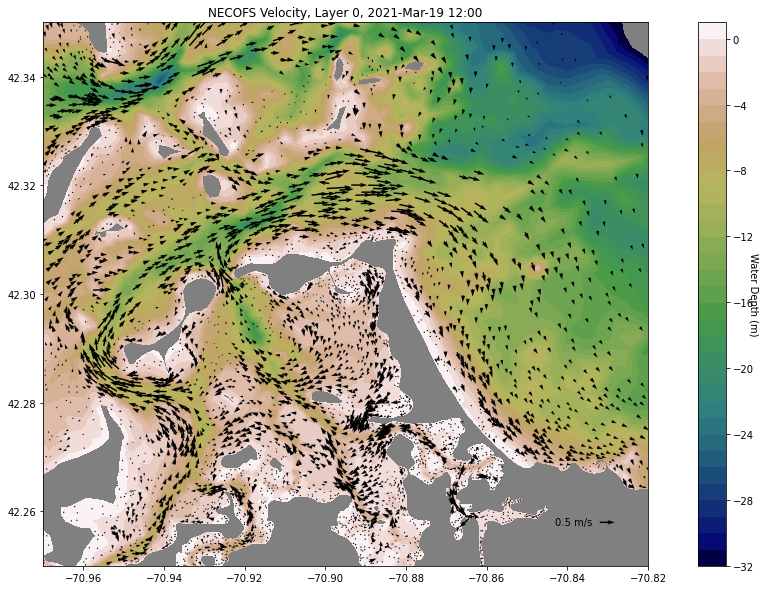

In [13]:
# tricontourf plot of water depth with vectors on top
fig1 = plt.figure(figsize=(18,10))
ax1 = fig1.add_subplot(111,aspect=(1.0/np.cos(np.mean(lat)*np.pi/180.0)))
plt.tricontourf(tri, -h,levels=levels,shading='faceted',cmap=plt.cm.gist_earth)
plt.axis(ax)
ax1.patch.set_facecolor('0.5')
cbar=plt.colorbar()
cbar.set_label('Water Depth (m)', rotation=-90)
Q = ax1.quiver(lonc[idv],latc[idv],u[idv],v[idv],scale=20)
qk = plt.quiverkey(Q,0.92,0.08,0.50,'0.5 m/s',labelpos='W')
plt.title('NECOFS Velocity, Layer %d, %s' % (ilayer, daystr))

*<p>Note:</p> 
<a href='http://gis.stackexchange.com/questions/71630/subsetting-a-curvilinear-netcdf-file-roms-model-output-using-a-lon-lat-boundin'>Here</a> is another example of subsetting a curvilinear netCDF file from ROMS model output using a lon/lat bounding box*

## Extract water levels, analyse & visualise

Using NetCDF4-Python we will extract information from the NETCOFS website and analyze/visualize them with Pandas. 

<small>
**Our aim is to plot forecast water levels from a list of lon,lat locations from the Massachusetts Bay.**
</small>

First, we define the list of stations we are interested in:
+ Boston,             42.368186, -71.047984
+ Scituate Harbor,    42.199447, -70.720090
+ Scituate Beach,     42.209973, -70.724523
+ Falmouth Harbor,    41.541575, -70.608020
+ Marion,             41.689008, -70.746576
+ Marshfield,         42.108480, -70.648691
+ Provincetown,       42.042745, -70.171180
+ Sandwich,           41.767990, -70.466219
+ Hampton Bay,        42.900103, -70.818510
+ Gloucester,         42.610253, -70.660570


In [14]:
# Enter desired (Station, Lat, Lon) values here:
x = '''
Station, Lat, Lon
Boston,             42.368186, -71.047984
Scituate Harbor,    42.199447, -70.720090
Scituate Beach,     42.209973, -70.724523
'''
# Create a Pandas DataFrame
obs=pd.read_csv(StringIO(x.strip()), sep=",\s*",index_col='Station',engine='python')
obs

,Lat,Lon
Station,,
Boston,42.368186,-71.047984
Scituate Harbor,42.199447,-70.720090
Scituate Beach,42.209973,-70.724523


Then, we define the list of URLs containing forecast model data for the area and we open them:

In [15]:
#NECOFS GOM3 grid forecast
#model='GOM3'
#url='http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_GOM3_FORECAST.nc'
#NECOFS MassBay grid forecast
model='Massbay'
url='http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc'

# Open NECOFS remote OPeNDAP dataset 
nc=netCDF4.Dataset(url).variables

We now search in the data for the nearest point to our stations location:

In [16]:
# Find the indices of the points in (x,y) closest to the points in (xi,yi)
def nearxy(x,y,xi,yi):
    ind=np.ones(len(xi),dtype=int)
    for i in np.arange(len(xi)):
        dist=np.sqrt((x-xi[i])**2+(y-yi[i])**2)
        ind[i]=dist.argmin()
    return ind

In [17]:
# Query to find closest NECOFS nodes to station locations
obs['NODE-ID'] = nearxy(nc['lon'][:],nc['lat'][:],obs['Lon'],obs['Lat'])
obs

,Lat,Lon,NODE-ID
Station,,,
Boston,42.368186,-71.047984,90913
Scituate Harbor,42.199447,-70.720090,37964
Scituate Beach,42.209973,-70.724523,28474


For all time steps, extract the water elevation for each station 

In [18]:
# Get time values and convert to datetime objects
times = nc['time']
jd = netCDF4.num2date(times[:],times.units)

# Get all time steps of water level from each station
nsta=len(obs)
z=np.ones((len(jd),nsta))
for i in range(nsta):
    z[:,i] = nc['zeta'][:,obs['NODE-ID'][i]]
    
# Make a DataFrame out of the interpolated time series at each location
zvals=pd.DataFrame(z,index=jd,columns=obs.index)

# List out a few values
zvals.head(4)

Station,Boston,Scituate Harbor,Scituate Beach
2021-03-16 00:00:00,-1.172309,0.486,-0.640000
2021-03-16 01:01:52.500000,-0.912606,0.486,-0.640000
2021-03-16 01:58:07.500000,-0.719965,0.486,-0.538636
2021-03-16 03:00:00,0.338090,0.486,0.221133


Now we can visualise the result for each station:

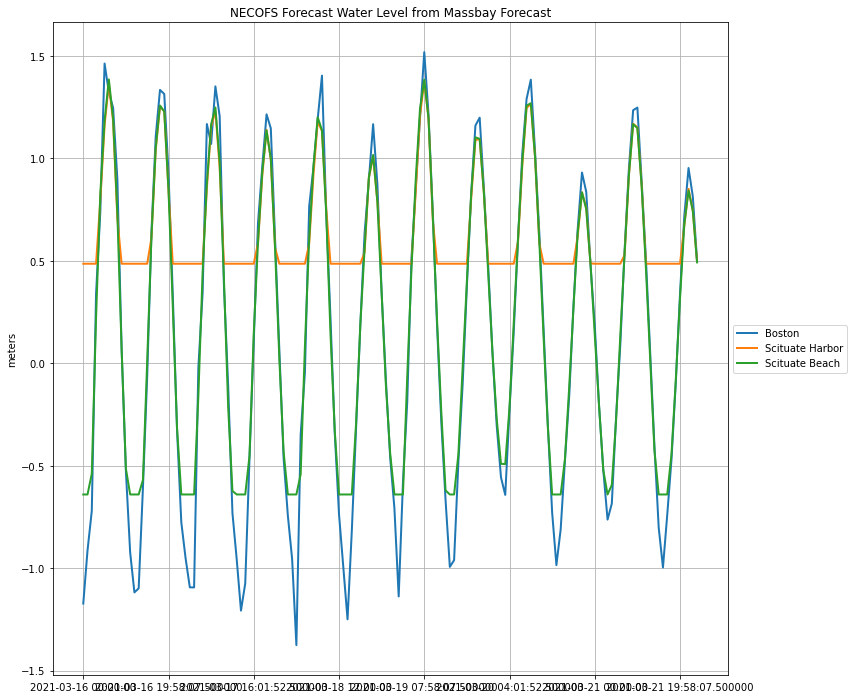

In [19]:
# Plotting the DataFrame
ax=zvals.plot(figsize=(22,12),grid=True,
              title=('NECOFS Forecast Water Level from %s Forecast' % model),
              legend=False,linewidth=2)

# Read units from dataset for ylabel
plt.ylabel(nc['zeta'].units)

# Plotting the legend outside the axis is a bit tricky
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.55, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));